<a href="https://colab.research.google.com/github/AtSourav/AE-w.-Bottleneck-Residual-Blocks/blob/main/AE_cifar10_residual_blocks_m3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a bigger model than m0-m2, and we shall try varying the latent dim.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

from google.colab import files

In [ ]:
#! git clone https://github.com/AtSourav/AE-w.-Bottleneck-Residual-Blocks

%cd "/content/AE-w.-Bottleneck-Residual-Blocks"

import Residual_blocks as resblock

/content/AE-w.-Bottleneck-Residual-Blocks


In [ ]:
img_ht = 32
img_wd = 32
input_size = (img_ht,img_wd,3)

batch_size = 128

### **Loading the dataset**

In [ ]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

# **Performance on different latent dimensions, same architecture, same seed**

performance with different latent dimensions:

192 < 256 < 512 < 288/384 < 320/336

# **Latent dim 320**

In [ ]:
K.clear_session()

latent_dim = 320

initializer = initializers.HeNormal(seed=123)

### **The model**

In [ ]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck (bridge_residual_conv2D                                      
 _block)                                                         
                                                                 
 bridge_residual_conv2d_blo  (None, 24, 24, 128)       230784    
 ck_1 (bridge_residual_conv                                      
 2D_block)                                                       
                                                                 
 residual_conv2d_block (res  (None, 24, 24, 128)       296192    
 idual_conv2D_block)                                             
                                                           

In [ ]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = resblock.bridge_residual_conv2Dtrans_block(1024, 1, 1, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer, padding='same')(x)

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer)(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320)]             0         
                                                                 
 dense_1 (Dense)             (None, 640)               205440    
                                                                 
 re_lu_25 (ReLU)             (None, 640)               0         
                                                                 
 dense_2 (Dense)             (None, 1280)              820480    
                                                                 
 re_lu_26 (ReLU)             (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 4096)              5246976   
                                                                 
 re_lu_27 (ReLU)             (None, 4096)              0   

In [ ]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()


Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 320)               17197056  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         23272835  
                                                                 
Total params: 40469891 (154.38 MB)
Trainable params: 40445699 (154.29 MB)
Non-trainable params: 24192 (94.50 KB)
_________________________________________________________________


In [ ]:
os.getcwd()

'/content/AE-w.-Bottleneck-Residual-Blocks'

### **Training**

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=10, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=100, callbacks=[callback])

Epoch 1/100
391/391 [==============================] - 102s 162ms/step - loss: 0.0354 - accuracy: 0.4839 - val_loss: 0.0309 - val_accuracy: 0.4900
Epoch 2/100
391/391 [==============================] - 56s 143ms/step - loss: 0.0224 - accuracy: 0.5347 - val_loss: 0.0250 - val_accuracy: 0.5573
Epoch 3/100
391/391 [==============================] - 59s 152ms/step - loss: 0.0185 - accuracy: 0.5858 - val_loss: 0.0209 - val_accuracy: 0.5981
Epoch 4/100
391/391 [==============================] - 59s 151ms/step - loss: 0.0170 - accuracy: 0.6053 - val_loss: 0.0178 - val_accuracy: 0.6055
Epoch 5/100
391/391 [==============================] - 57s 147ms/step - loss: 0.0159 - accuracy: 0.6135 - val_loss: 0.0169 - val_accuracy: 0.6105
Epoch 6/100
391/391 [==============================] - 58s 147ms/step - loss: 0.0149 - accuracy: 0.6190 - val_loss: 0.0156 - val_accuracy: 0.6220
Epoch 7/100
391/391 [==============================] - 56s 144ms/step - loss: 0.0143 - accuracy: 0.6257 - val_loss: 0.0156 

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=1, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.00005)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, callbacks=[callback])

Epoch 1/30
391/391 [==============================] - 86s 147ms/step - loss: 0.0051 - accuracy: 0.7529 - val_loss: 0.0089 - val_accuracy: 0.7314
Epoch 2/30
391/391 [==============================] - 57s 147ms/step - loss: 0.0050 - accuracy: 0.7529 - val_loss: 0.0090 - val_accuracy: 0.7436
Epoch 3/30
391/391 [==============================] - 57s 146ms/step - loss: 0.0050 - accuracy: 0.7532 - val_loss: 0.0088 - val_accuracy: 0.7377
Epoch 4/30
391/391 [==============================] - 57s 146ms/step - loss: 0.0050 - accuracy: 0.7536 - val_loss: 0.0089 - val_accuracy: 0.7299
Epoch 5/30
391/391 [==============================] - 57s 146ms/step - loss: 0.0050 - accuracy: 0.7544 - val_loss: 0.0089 - val_accuracy: 0.7227
Epoch 6/30
391/391 [==============================] - 57s 146ms/step - loss: 0.0050 - accuracy: 0.7541 - val_loss: 0.0093 - val_accuracy: 0.7339
Epoch 7/30
391/391 [==============================] - 55s 141ms/step - loss: 0.0050 - accuracy: 0.7538 - val_loss: 0.0087 - val_ac

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.00001, decay_steps=1564, decay_rate=0.75)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, start_from_epoch=12, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = lr_schedule)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, callbacks=[callback])

Epoch 1/30
391/391 [==============================] - 85s 147ms/step - loss: 0.0044 - accuracy: 0.7583 - val_loss: 0.0087 - val_accuracy: 0.7410
Epoch 2/30
391/391 [==============================] - 57s 146ms/step - loss: 0.0044 - accuracy: 0.7599 - val_loss: 0.0087 - val_accuracy: 0.7380
Epoch 3/30
391/391 [==============================] - 55s 142ms/step - loss: 0.0043 - accuracy: 0.7597 - val_loss: 0.0086 - val_accuracy: 0.7405
Epoch 4/30
391/391 [==============================] - 57s 146ms/step - loss: 0.0043 - accuracy: 0.7599 - val_loss: 0.0087 - val_accuracy: 0.7402
Epoch 5/30
391/391 [==============================] - 57s 146ms/step - loss: 0.0043 - accuracy: 0.7603 - val_loss: 0.0087 - val_accuracy: 0.7429
Epoch 6/30
391/391 [==============================] - 57s 146ms/step - loss: 0.0043 - accuracy: 0.7602 - val_loss: 0.0087 - val_accuracy: 0.7407
Epoch 7/30
391/391 [==============================] - 55s 142ms/step - loss: 0.0043 - accuracy: 0.7604 - val_loss: 0.0087 - val_ac

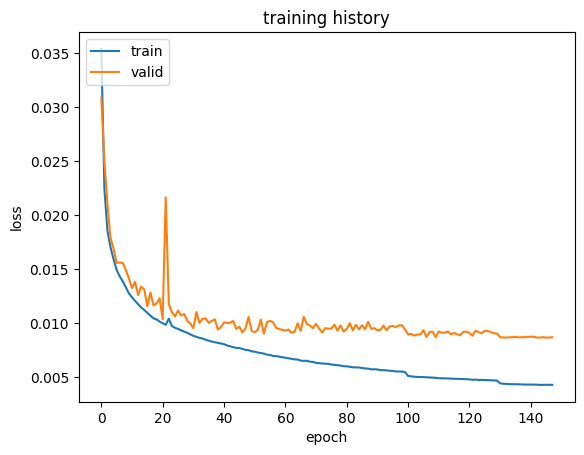

In [ ]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss'])

plt.title('training history')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','valid'], loc='upper left')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/Training_m3.png')
plt.show()

In [ ]:
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/Training_m3.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Reconstructions based on the above**

In [ ]:
def plot_reconstruction(set, name,seed_val, epochs, scale, model_name):     #name should be either 'training' or 'validation'
                                                                            #scale decides how big the images are
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(np.ceil(9*scale),np.ceil(4*scale)))
  recon.suptitle(model_name + ' with latent_dim = ' + str(latent_dim) +': reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs', fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

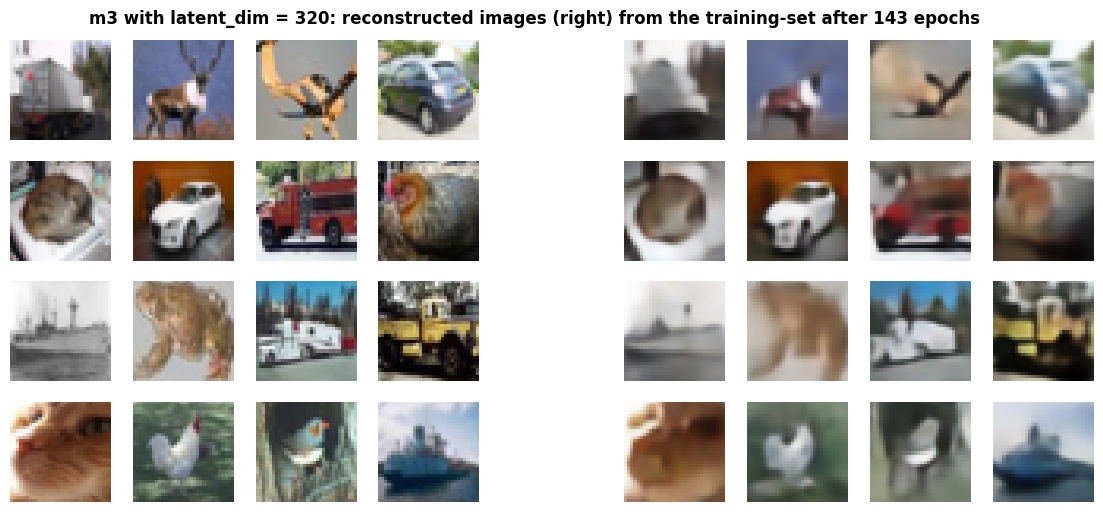

In [ ]:
plot_reconstruction(img_train, 'training', 123, 143, 1.5, 'm3')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_reconstructions_TrainSet_1.png')

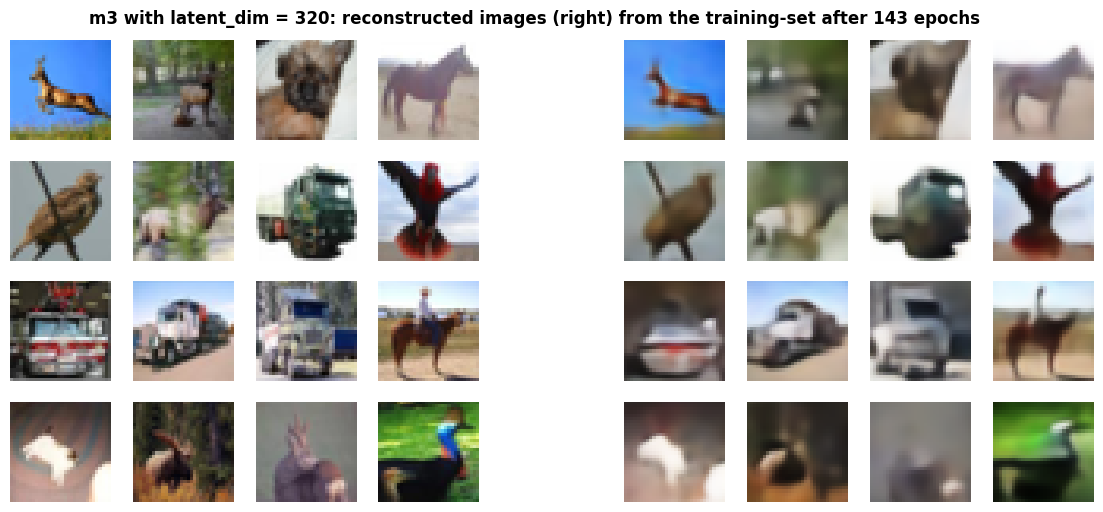

In [ ]:
plot_reconstruction(img_train, 'training', 1000, 143, 1.5, 'm3')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_reconstructions_TrainSet_2.png')

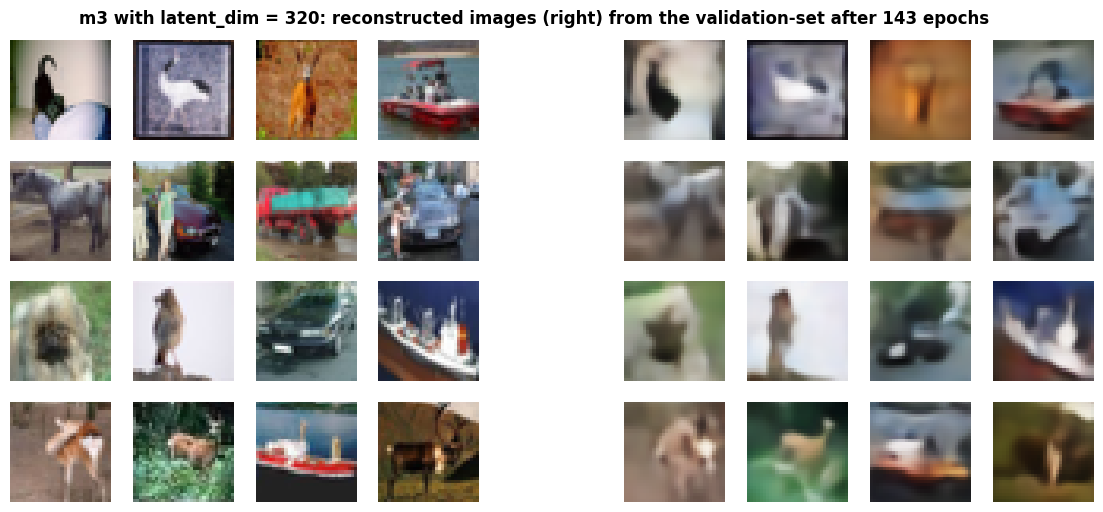

In [ ]:
plot_reconstruction(img_valid, 'validation', 123, 143, 1.5, 'm3')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_reconstructions_ValidSet_1.png')

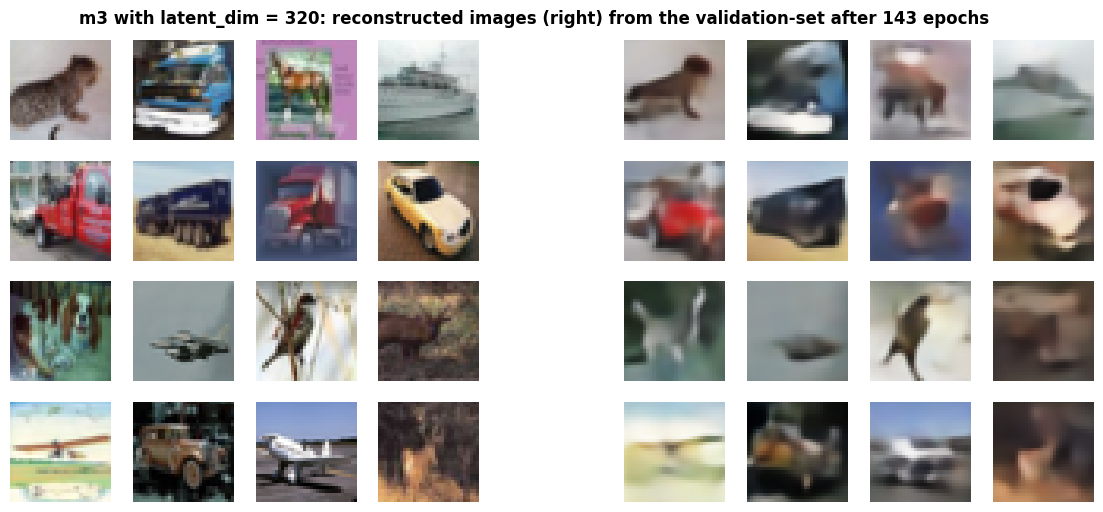

In [ ]:
plot_reconstruction(img_valid, 'validation', 1000, 143, 1.5, 'm3')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_reconstructions_ValidSet_2.png')

**Conclusions**

The training set reconstructions look decent, finished training with a 76.05% accuracy. The validation set reconstructions are not as good, concluded training at the highest validation set accuracy of 74.38%

In [ ]:
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_reconstructions_TrainSet_1.png')
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_reconstructions_TrainSet_2.png')
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_reconstructions_ValidSet_1.png')
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_reconstructions_ValidSet_2.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>